# Practice Session PS05: Recommendation engines (Content-based)

For this assignment we will build and use a content-based recommender system for movies. This content-based recommender will take as input a database of users and ratings on movies.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Author: <font color="blue">Josip Hanak</font>

E-mail: <font color="blue">josip.hanak@fer.hr</font>

Date: <font color="blue">8/11/2022</font>

# 0. The Movies dataset

One of the most widely used datasets for video/movies recommendation is the one built by the University of Minnesota, known as the [MovieLens DataSet](https://grouplens.org/datasets/movielens/). In this assignment we are going to use the 25M version, which was released in late 2019.

We will use a sub-set containing only movies released in the 2000s, and only 20% of the users and all of their ratings.

**MOVIES** are described in `movies-2000s.csv` in the following format: `movieId,title,genres`.

- Titles include the year of release in paranthesis, the year is greater or equal to 2000
- Genres are pipe-separated ("|") and are selected from the following genres: 'Musical', 'Horror', 'Comedy', 'Crime', 'Western', 'Sci-Fi', 'Documentary', 'Adventure', 'IMAX', 'Drama', 'Fantasy', 'Children', 'War', 'Thriller', 'Mystery', 'Action', 'Romance', 'Film-Noir', 'Animation' or '(no genres listed)'.

**RATINGS** are contained in `ratings-2000s.csv` in the following format: `userId,movieId,rating`

- Ratings are made on a 5-star scale
- This has been filtered to contain only movies released in the 2000s, and to sample 20% of rows

**TAGS** are contained in `tags-2000s.csv` in the following format: `userId,movieId,tag,timestamp`

- Timestamp is represented in seconds since the epoch as returned by time(2).
- Tags are words or short phrases, they are user-generated and can be anything

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [2]:
import pandas as pd   
import numpy as np  
import re
import matplotlib.pyplot as plt  
from math import*
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 1. Load and join the dataset

The following code, which you should leave as-is, loads the 3 dataset within three dataframes named `movies`,  `ratings` and `tags` considering the data structure explained above.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [3]:
# Leave this code as-is

FILENAME_MOVIES = "movies-2000s.csv"
FILENAME_RATINGS = "ratings-2000s.csv"
FILENAME_TAGS = "tags-2000s.csv"


In [4]:
# Leave this code as-is

movies = pd.read_csv(FILENAME_MOVIES, 
                    sep=',', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])
display(movies.head(5))

ratings_raw = pd.read_csv(FILENAME_RATINGS, 
                    sep=',', 
                    encoding='latin-1',
                    engine='python',
                    names=['user_id', 'movie_id', 'rating'])
display(ratings_raw.head(5))

,movie_id,title,genres
0,2769,"Yards, The (2000)",Crime|Drama
1,3177,Next Friday (2000),Comedy
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller
3,3225,Down to You (2000),Comedy|Romance
4,3228,Wirey Spindell (2000),Comedy


,user_id,movie_id,rating
0,4,1,3.0
1,4,260,3.5
2,4,296,4.0
3,4,541,4.5
4,4,589,4.0


In [9]:
def yearof(title):
    numbers = (re.findall(r'\(\s*\+?(-?\d+)\s*\)', title))
    for i in range(len(numbers)):
        if len(numbers[i]) == 4:
            return numbers[i]

print(yearof("The Emoji Movie (300) (2017)"))

2017


<font size="+1" color="red">Replace this cell with your own code to add a `year` column to the `movies` dataframe.</font>

In [10]:
#if you have a function named f that takes the column a of dataframe df, and produces a value you want to store in column b 
#of the same dataframe, you can use:
#df['b'] = df.apply(lambda x: f(x['a']), axis=1)

movies['year'] = movies.apply(lambda x: yearof(x['title']), axis=1)

<font size="+1" color="red">Replace this cell with a brief commentary indicating on which field you can join ratings_raw and users, and on which field you can join ratings_raw and movies.</font>

Ratings_raw and movies can be joined on the field movieID
Ratings_raw and users(tags?) can be joined on the field movieID and userID, movieID, userID

<font size="+1" color="red">Replace this cell with your own code to join the datasets into a single dataframe named "ratings". Your dataframe should have the following columns: user_id, movie_id, rating, title, genders, year</font>

In [11]:
ratings = pd.merge(ratings_raw, movies, how='inner', on='movie_id')

In [12]:
display(ratings.head(5))

,user_id,movie_id,rating,title,genres,year
0,4,3624,2.5,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
1,152,3624,3.0,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
2,171,3624,3.5,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
3,276,3624,4.0,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
4,494,3624,3.5,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000


<font size="+1" color="red">Replace this cell with your code for find _movies</font>

In [85]:
def find_movies(keyword):
    return_movies = movies[movies['title'].str.contains(keyword)]
    final = "movie_id: "+return_movies["movie_id"].astype(str) +", title: "+ return_movies["title"].astype(str)
    final = final.to_numpy()
    return final

In [86]:
print(find_movies("Barcelona"))


['movie_id: 60950, title: Vicky Cristina Barcelona (2008)'
 'movie_id: 182911, title: Barcelona Christmas Night (2015)']


# 2. Exploratory Data Analysis

## 2.1. "Ratings" variable

In [15]:
# Leave this code as-is
ratings['rating'].describe()

count    472971.000000
mean          3.462222
std           1.076063
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

<font size="+1" color="red">Replace this cell with your code to plot a histogram of ratings. Include in the x axis the rating (1, 2, 3, 4, or 5) and in the y axis the probability of having that rating. Remember to label both axes.</font>

[0.05007407607850035, 0.10544848160951421, 0.2673740537542027, 0.39405091292847433, 0.18305247562930843]


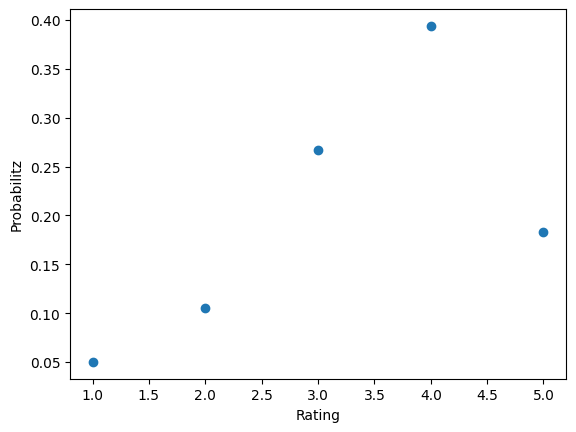

In [17]:
x_axis =  list(range(1,6))
y_axis = []
for rating in x_axis:
    rating = float(rating)
    num_of_rating = len(ratings[ratings['rating']==rating])
    y_axis.append(num_of_rating)
probabilities = [num/sum(y_axis) for num in y_axis]
print(probabilities)
plt.xlabel("Rating")
plt.ylabel("Probabilitz")
plt.scatter(x_axis, probabilities)
#plt.hist(ratings.rating)
plt.show()



<font size="+1" color="red">Replace this cell with a brief commentary on what you observe in the distribution of ratings.</font>

The most common rating is 4 then 3, probably because of the rating bias meaning that users
who dont know what to put in the rating place a 4 or 3 because it is a median.

<font size="+1" color="red">Replace this cell with code to print the 10 movies with the most "good" ratings (i.e., ratings that are larger than 4.0), and the 10 movies with the most "bad" ratings (i.e., ratings than are smaller than 2.0)</font>

In [89]:
good_ratings = ratings[ratings["rating"] > 4.0]
bad_ratings = ratings[ratings["rating"] < 2.0]

In [95]:
display(good_ratings.title.value_counts(normalize=True).head(10))

Lord of the Rings: The Fellowship of the Ring, The (2001)    0.029013
Lord of the Rings: The Return of the King, The (2003)        0.026849
Lord of the Rings: The Two Towers, The (2002)                0.025868
Memento (2000)                                               0.021002
Gladiator (2000)                                             0.017646
Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)        0.017319
Eternal Sunshine of the Spotless Mind (2004)                 0.016454
Spirited Away (Sen to Chihiro no kamikakushi) (2001)         0.013251
Kill Bill: Vol. 1 (2003)                                     0.013078
Shrek (2001)                                                 0.012607
Name: title, dtype: float64

In [94]:
display(bad_ratings.title.value_counts(normalize=True).head(10))

Charlie's Angels (2000)                                      0.009514
Battlefield Earth (2000)                                     0.008923
Scary Movie (2000)                                           0.008331
Star Wars: Episode II - Attack of the Clones (2002)          0.007712
Mission: Impossible II (2000)                                0.006868
American Pie 2 (2001)                                        0.006389
Lord of the Rings: The Fellowship of the Ring, The (2001)    0.006277
Lord of the Rings: The Return of the King, The (2003)        0.006277
Pearl Harbor (2001)                                          0.006277
Matrix Revolutions, The (2003)                               0.006023
Name: title, dtype: float64

<font size="+1" color="red">Replace this cell with a brief commentary on what you observe in these lists.</font>

In [ ]:
It is very interesting that two of the movies in the top 10 best rated movies are in the most badly rated movies
(The Lord Of The Rings). Probably it is because they are the most popular movies with the most ratings
and because of that there is a higher chance of both good and bad ratings.

## 2.2. Genres distribution

<font size="+1" color="red">Replace this cell with code to list all genres in the dataset. Verify the list has 18 genres.</font>

In [20]:
genre_types = set()
for row in range(len(movies)):
    genres = movies.loc[row].genres.split("|")
    genre_types.update(genres)
    if len(genre_types) == 20:
        break
print(genre_types)

#list has 20 items??

{'Thriller', 'Adventure', 'Film-Noir', 'Fantasy', 'Musical', 'Documentary', 'Sci-Fi', 'Action', 'Crime', 'Drama', 'Comedy', 'Children', 'War', 'Romance', 'Horror', 'Western', 'IMAX', '(no genres listed)', 'Animation', 'Mystery'}


Print a table listing the genres you see in this dataset, sorted from the most frequent to the least frequent. Notice that these frequencies may add up to more than the number of movies in the dataset, as a movie may have more than one genre.

Your output should look like this:

```python
[['Drama', 13666],
 ['Comedy', 8898],
 ['Thriller', 5437],
 ['Documentary', 4473],
 ['Action', 3901],
 ['Romance', 3846],
 ['Horror', 3431],
 ['Crime', 2425],
 ['(no genres listed)', 2200],
 ['Sci-Fi', 1907],
 ['Adventure', 1906],
 ['Children', 1639],
 ['Animation', 1553],
 ['Mystery', 1516],
 ['Fantasy', 1456],
 ['War', 679],
 ['Musical', 308],
 ['Western', 194],
 ['IMAX', 173],
 ['Film-Noir', 21]]
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code to obtain the frequency of each genre, check that it returns the same result as above.</font>

In [23]:
def produce_keyword_occurences(DataFrame):
    #initialize dict and combine genre types with 0
    keyword_occurences = dict.fromkeys(genre_types, 0)
    #count the number of occurences for each key
    for genre in keyword_occurences.keys():
        #movies[movies['title'].str.contains(keyword)]
        keyword_occurences[genre] = len(DataFrame[DataFrame["genres"].str.contains(genre)])
    #sort
    keyword_occurences = dict(reversed(sorted(keyword_occurences.items(), key=lambda item: item[1])))
    return keyword_occurences

In [31]:
keyword_occurences = produce_keyword_occurences(movies)
print("{" + "\n".join("{!r}: {!r},".format(k, v) for k, v in keyword_occurences.items()) + "}")

{'Drama': 13666,
'Comedy': 8898,
'Thriller': 5437,
'Documentary': 4473,
'Action': 3901,
'Romance': 3846,
'Horror': 3431,
'Crime': 2425,
'(no genres listed)': 2200,
'Sci-Fi': 1907,
'Adventure': 1906,
'Children': 1639,
'Animation': 1553,
'Mystery': 1516,
'Fantasy': 1456,
'War': 679,
'Musical': 308,
'Western': 194,
'IMAX': 173,
'Film-Noir': 21,}


C:\Users\josip\AppData\Local\Temp\ipykernel_3692\2406153179.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  keyword_occurences[genre] = len(DataFrame[DataFrame["genres"].str.contains(genre)])


In [32]:
# Change the colors/style if you want

# Generate the word cloud
def generate_world_cloud(key_occ):
    genre_wordcloud = WordCloud(width=1000, height=400, background_color='white')
    genre_wordcloud.generate_from_frequencies(dict(key_occ))

    # Plot the word cloud
    f, ax = plt.subplots(figsize=(16, 8))
    plt.imshow(genre_wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

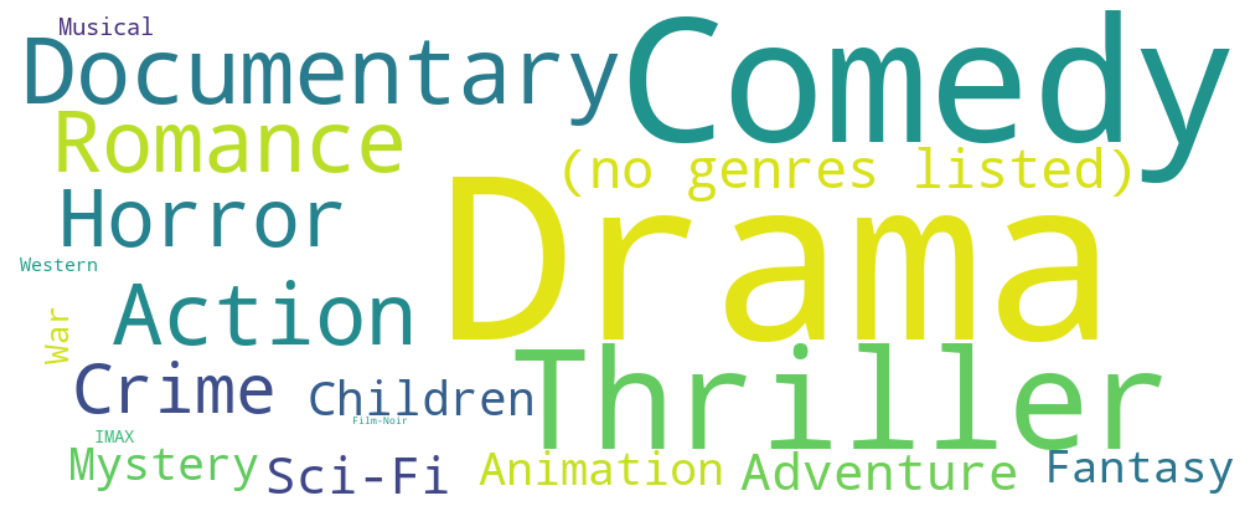

In [33]:
generate_world_cloud(keyword_occurences)

<font size="+1" color="red">Produce two word clouds: one for movies filmed before 2010, and another for movies filmed after 2010, and compare them. Do you notice any difference?</font>

C:\Users\josip\AppData\Local\Temp\ipykernel_3692\2406153179.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  keyword_occurences[genre] = len(DataFrame[DataFrame["genres"].str.contains(genre)])


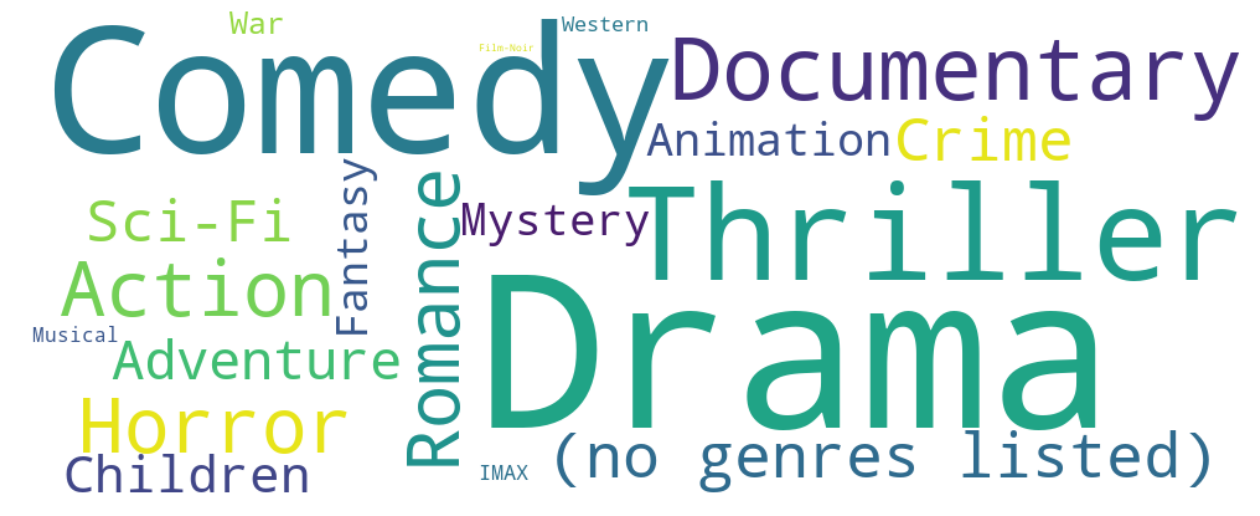

In [34]:
movies_after_2010 =  movies[movies.year >= str(2010)]
key_occ_after_2010 = produce_keyword_occurences(movies_after_2010)
generate_world_cloud(key_occ_after_2010)

C:\Users\josip\AppData\Local\Temp\ipykernel_3692\2406153179.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  keyword_occurences[genre] = len(DataFrame[DataFrame["genres"].str.contains(genre)])


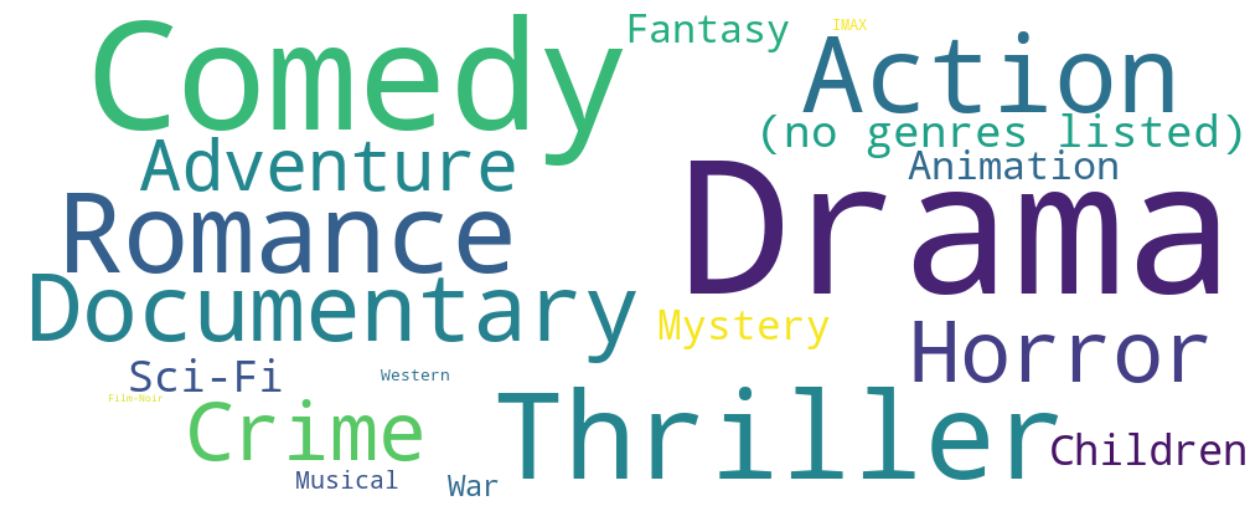

In [35]:
movies_before_2010 =  movies[movies.year < str(2010)]
key_occ_before_2010 = produce_keyword_occurences(movies_before_2010)
generate_world_cloud(key_occ_before_2010)

In [ ]:
I notice that Sci-Fi movies are more popular after 2010 (probably because it is a newer genre that hadnt existed before).
Also Action genre has become less popular (which I can suppose because the golden era of action movies where the 2000s). 
In general there is a shift in the popularity of genres which is dependent on the trend of the genre.

# 3. Content-based recommendation

A content-based recommender works with data that describes the movie (or content). In our case, we will mainly use the genres that describes each movie. Our assumption is that films in the same genres should have similar contents and therefore are more likely to be recommended.

We *could* extend the content-based taking into account the title or any other text-based characteristics of the movie. We could also extend it using other attributes of the movie, even if they are not text. Content-based recommendations just means that we somehow compute the similarity between the items and then recommend the most similar items.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

## 3.1. Compute TF-IDF vectors

**Term Frequency (TF)** and **Inverse Document Frequency (IDF)** are techniques used in information retrieval to determine the **importance** of a word. In our use case, content-based recommendation, TF-IDF will be used to measure the importance of each genre in each movie. 

TF is simply the frequency of a word in a document, IDF is the inverse of the document frequency among the whole corpus of documents. Usually, TF and IDF are combined to measure the relevance of a word or term across different documents.

In a nutshell, TF-IDF weights infrequent words (in our case genres) more heavily. This means that two movies that share many uncommon genres will be considered more similar than two movies that share many common genres.

The TF-IDF score is computed as:

**tfidf(keyword, document) = TF(keyword, document) x IDF(keyword)**

Where:

* **TF(keyword, doc)** is the number of times the *keyword* appears in the *document*
* **IDF(keyword)** is **log(N/docfreq(keyword))** where **N** is the total number of documents and **docfreq(keyword)** is the number of documents containing the **keyword**

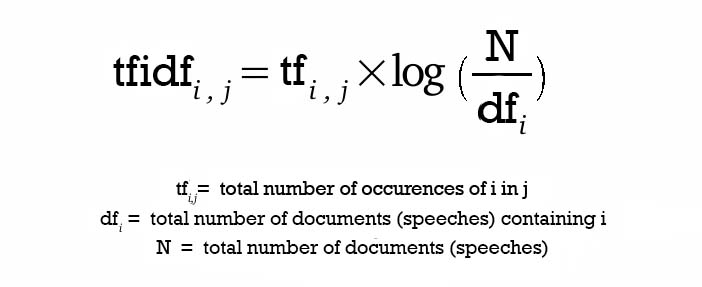

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to add column "genres_arr" to the dataframe "movies".</font>

In [41]:
#split into array of strings
movies["genres_arr"] = movies['genres'].str.split('|')
#fill nan
movies['genres_arr'].fillna('').astype('str')


0                         ['Crime', 'Drama']
1                                 ['Comedy']
2        ['Adventure', 'Sci-Fi', 'Thriller']
3                      ['Comedy', 'Romance']
4                                 ['Comedy']
                        ...                 
33163        ['Action', 'Comedy', 'Romance']
33164                              ['Drama']
33165                        ['Documentary']
33166                    ['Comedy', 'Drama']
33167                 ['(no genres listed)']
Name: genres_arr, Length: 33168, dtype: object

In [42]:
display(movies.head(10))

,movie_id,title,genres,year,genres_arr
0,2769,"Yards, The (2000)",Crime|Drama,2000,"[Crime, Drama]"
1,3177,Next Friday (2000),Comedy,2000,[Comedy]
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller,2000,"[Adventure, Sci-Fi, Thriller]"
3,3225,Down to You (2000),Comedy|Romance,2000,"[Comedy, Romance]"
4,3228,Wirey Spindell (2000),Comedy,2000,[Comedy]
5,3239,Isn't She Great? (2000),Comedy,2000,[Comedy]
6,3273,Scream 3 (2000),Comedy|Horror|Mystery|Thriller,2000,"[Comedy, Horror, Mystery, Thriller]"
7,3275,"Boondock Saints, The (2000)",Action|Crime|Drama|Thriller,2000,"[Action, Crime, Drama, Thriller]"
8,3276,Gun Shy (2000),Comedy,2000,[Comedy]
9,3279,Knockout (2000),Action|Drama,2000,"[Action, Drama]"


Verify by running the next cell. It should print:

```
Transformed: Adventure|Sci-Fi|Thriller → ['Adventure', 'Sci-Fi', 'Thriller']
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [43]:
# Leave this code as-is

print("Transformed: %s → %s" % (movies['genres'][2], movies['genres_arr'][2]))

Transformed: Adventure|Sci-Fi|Thriller → ['Adventure', 'Sci-Fi', 'Thriller']


In [73]:
# LEAVE AS-IS

# The reset-index is important to match row/column numbers in the tdifd-matrix

movies_filtered = movies[movies.year > str(2015)]
movies_filtered = movies_filtered.reset_index()
display(movies_filtered.head(5))

,index,movie_id,title,genres,year,genres_arr
0,10897,122888,Ben-hur (2016),(no genres listed),2016,[(no genres listed)]
1,10898,122890,Warcraft (2016),Action|Adventure|Fantasy,2016,"[Action, Adventure, Fantasy]"
2,10900,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed),2017,[(no genres listed)]
3,10901,122898,Justice League (2017),Action|Adventure|Sci-Fi,2017,"[Action, Adventure, Sci-Fi]"
4,10904,122904,Deadpool (2016),Action|Adventure|Comedy|Sci-Fi,2016,"[Action, Adventure, Comedy, Sci-Fi]"


<font size="+1" color="red">Replace this cell with your code to generate "tfidf_matrix"</font>

In [45]:
genres_array = [" ".join(genre) for genre in movies_filtered["genres_arr"].values]
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(genres_array)
#vectorizer.get_feature_names_out()
tfidf_matrix.shape

(7890, 130)

## 3.2. Calculate most similar movies

As previously explained, the calculated TF-IDF from **genre** will be the variable to describe the content; i.e. in our case, the movie. 
The **similarity** will be measured considering the angle between the vectors generated after the TF-IDF process. Each movie becomes a vector of attributes in an **n-dimensional space** where the angles between the vectors **determines the similarity**. 
The method of calculating this relative measure is taking the cosine of the angle between two vectors. The vectors are length normalized and then the cosine calculation is simply the sum-product of vectors. 

For a more generic perspective, the next image is an example of several sentences represented by its vector space where Sentence 2 is more likely to be using Term 2 than using Term 1.

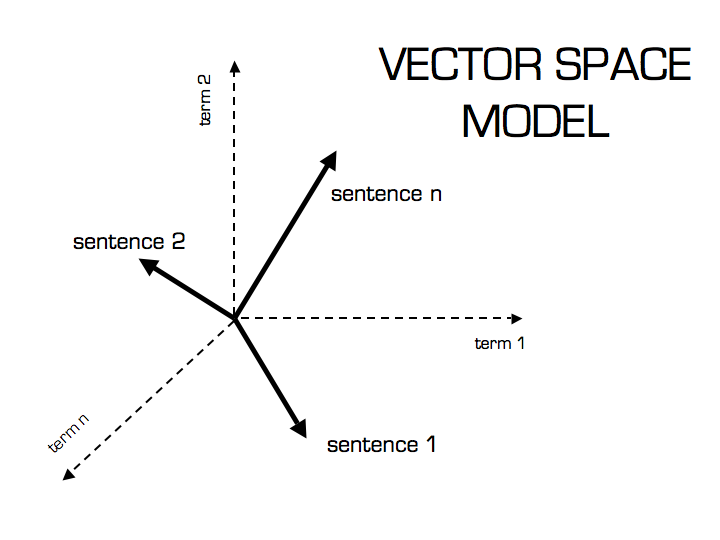

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

The next code, which you should leave as-is, uses sklearn's [linear_kernel](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.linear_kernel.html) function, which is a fast way of computing these similarities on a matrix.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [46]:
# Leave this code as-is

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1.         0.         1.         ... 1.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [1.         0.         1.         ... 1.         0.         0.        ]
 ...
 [1.         0.         1.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.41022264]
 [0.         0.         0.         ... 0.         0.41022264 1.        ]]


In [47]:
# Leave this code as-is

# Create an index to convert from numbers to movie_id
movie_id_to_index = pd.Series(movies_filtered.index, index=movies_filtered['movie_id'])

# Print the similarity vector
def print_similarity_vector(movie_id, similarities):
    
    # Determine the index of the movie_id
    index_source = movie_id_to_index[movie_id]
    
    # Get the row in the similarities matrix
    sim_scores = list(similarities[index_source])

    # Iterate through that row
    for index_target in range(len(sim_scores)):
        print("%.3f %d %s" %
              (sim_scores[index_target], movies_filtered.iloc[index_target].movie_id, movies_filtered.iloc[index_target].title))
        
print_similarity_vector(122904, cosine_sim)

0.000 122888 Ben-hur (2016)
0.362 122890 Warcraft (2016)
0.000 122896 Pirates of the Caribbean: Dead Men Tell No Tales (2017)
0.600 122898 Justice League (2017)
1.000 122904 Deadpool (2016)
0.600 122906 Black Panther (2017)
0.600 122908 Inhumans (2018)
0.600 122910 Captain Marvel (2018)
0.600 122912 Avengers: Infinity War - Part I (2018)
0.600 122914 Avengers: Infinity War - Part II (2019)
0.600 122916 Thor: Ragnarok (2017)
0.600 122918 Guardians of the Galaxy 2 (2017)
0.359 122920 Captain America: Civil War (2016)
0.600 122922 Doctor Strange (2016)
0.504 122924 X-Men: Apocalypse (2016)
0.362 122926 Untitled Spider-Man Reboot (2017)
0.440 135141 Allegiant: Part 1 (2016)
0.000 135143 Fantastic Beasts and Where to Find Them (2016)
0.000 135426 Fantastic Beasts and Where to Find Them 2 (2018)
0.056 135436 The Secret Life of Pets (2016)
0.326 135530 Criminal (2016)
0.309 135536 Suicide Squad (2016)
0.600 135567 Independence Day: Resurgence (2016)
0.600 135569 Star Trek Beyond (2016)
0.000 

0.000 168244 Maigret's Dead Man (2016)
0.301 168246 ISRA 88 (2016)
0.080 168248 John Wick: Chapter Two (2017)
0.000 168250 Get Out (2017)
0.419 168252 Logan (2017)
0.362 168254 Kong: Skull Island (2017)
0.000 168262 City of Tiny Lights (2016)
0.000 168266 T2: Trainspotting (2017)
0.074 168274 Patient Zero (2017)
0.311 168276 Passage to Mars (2016)
0.000 168286 Before I Fall (2017)
0.083 168288 The Belko Experiment (2017)
0.066 168326 The Big Sick (2017)
0.087 168328 Ingrid Goes West (2017)
0.000 168330 I Don't Feel at Home in This World Anymore (2017)
0.087 168334 Chocolat (2016)
0.000 168340 The Case of: JonBenÃ©t Ramsey (2016)
0.322 168344 King Arthur: Legend of the Sword (2017)
0.000 168346 The Rolling Stones OlÃ© OlÃ© OlÃ©! : A Trip Across Latin America (2016)
0.108 168348 Headshot (2016)
0.000 168350 100 Streets (2016)
0.000 168352 Incarnate (2016)
0.000 168366 Beauty and the Beast (2017)
0.178 168370 Take the L (2017)
0.000 168402 Love, Lies (2016)
0.064 168408 Boo! A Madea Hallo

0.000 177521 Photon (2017)
0.000 177523 El mar la mar (2017)
0.000 177529 Dying Laughing (2017)
0.000 177533 Cruel (2017)
0.000 177539 Nick (2016)
0.178 177541 Fell, Jumped or Pushed (2016)
0.178 177545 #realityhigh (2017)
0.178 177555 Ali's Wedding (2017)
0.178 177561 Do It Like An Hombre (2017)
0.178 177565 Marc Maron: Too Real (2017)
0.720 177567 Gun Shy (2017)
0.000 177569 Circus Kane (2017)
0.000 177575 Polina (2017)
0.000 177585 Star Boys (2017)
0.178 177587 L'Ascension (2017)
0.000 177593 Three Billboards Outside Ebbing, Missouri (2017)
0.000 177601 Western (2017)
0.076 177605 Operation Dunkirk (2017)
0.108 177607 American Assassin (2017)
0.000 177611 Pyewacket (2017)
0.178 177615 Lady Bird (2017)
0.108 177617 PolÃ­cia Federal - A Lei Ã© Para Todos (2017)
0.000 177619 Cold Tango (2017)
0.000 177645 ClownTown (2016)
0.000 177651 The Florida Project (2017)
0.000 177655 Man in Red Bandana (2017)
0.000 177689 The Killing of a Sacred Deer (2017)
0.419 177705 Rogue Warrior: Robot Figh

0.000 184797 Papers, Please: The Short Film (2018)
0.000 184801 Born Strong (2017)
0.178 184803 Little Bitches (2018)
0.087 184807 Padman (2018)
0.000 184821 The Pulitzer At 100 (2017)
0.064 184825 Another Wolfcop (2016)
0.040 184829 ZombillÃ©nium (2017)
0.349 184831 Guardians of the Tomb (2018)
0.000 184835 Lu Over the Wall (2017)
0.000 184855 A Gentle Creature (2017)
0.000 184859 A Stray (2016)
0.000 184861 The Founding Of An Army (2017)
0.026 184865 Sherlock Gnomes (2018)
0.057 184867 People You May Know (2017)
0.000 184869 Golden Slumber (2018)
0.000 184871 Western World (2017)
0.000 184885 Erase and Forget (2017)
0.000 184887 Meditation Park (2017)
0.000 184889 Mary Goes Round (2017)
0.000 184891 Don't Talk to Irene (2017)
0.000 184893 Ava (2017)
0.000 184897 In-Shadow: A Modern Odyssey (2017)
0.000 184905 Manolo: The Boy Who Made Shoes for Lizards (2017)
0.066 184907 Half Magic (2018)
0.532 184909 Operation Red Sea (2018)
0.000 184917 Bowie: The Man Who Changed the World (2016)
0

0.000 191497 Bisbee '17 (2018)
0.178 191511 In the Game (2018)
0.000 191513 American Jihad (2017)
0.000 191635 Pretty Little Dead Girl (2017)
0.000 191643 Little Pink House (2018)
0.000 191651 Red Istanbul (2017)
0.000 191653 The Envelope (2017)
0.000 191657 Memory Hackers (2016)
0.000 191661 Shot! The Psycho-Spiritual Mantra of Rock (2016)
0.000 191663 Apostasy (2017)
0.050 191669 The Ice Cream Truck (2017)
0.000 191679 Scotty and the Secret History of Hollywood (2018)
0.000 191687 Teen Titans Go! To the Movies (2018)
0.000 191695 be vaght sham (2018)
0.178 191699 Hezarpa (2018)
0.000 191707 The Truth Beneath (2016)
0.087 191709 Yourself and Yours (2016)
0.336 191715 Snake Outta Compton (2018)
0.064 191717 I Had A Bloody Good Time At House Harker (2016)
0.131 191719 Mercy Christmas (2017)
0.178 191721 5 Doctors (2016)
0.000 191723 The Day After (2017)
0.000 191725 Makala (2017)
0.000 191727 Peelers (2016)
0.000 191733 Le passÃ© devant nous (2017)
0.000 191739 A Man and a Woman (2016)


0.000 197443 American Hangman (2019)
0.118 197449 Tea Pets (2017)
0.000 197453 303 (2018)
0.352 197455 Meatball Machine Kodoku (2018)
0.000 197469 Lift (2016)
0.083 197485 The Car: Road to Revenge (2019)
0.000 197489 3/4 (2017)
0.000 197491 Brexit: The Uncivil War (2019)
0.000 197495 MARS: Inside SpaceX (2018)
0.000 197505 Chaplin in Bali (2017)
0.000 197507 He Knows Your Every Move (2018)
0.000 197509 One Last Deal (2019)
0.178 197523 Summer '03 (2018)
0.000 197525 American Dream/American Knightmare (2018)
0.087 197529 The Upside (2019)
0.000 197531 Webcast (2018)
0.000 197537 Velvet Buzzsaw (2019)
0.139 197539 Wheely (2018)
0.000 197547 The Farm (2018)
0.000 197549 My Tomorrow, Your Yesterday (2016)
0.281 197551 Mail Order Monster (2018)
0.068 197553 Buffalo Boys (2018)
0.151 197557 Simmba (2018)
0.000 197559 FaÃ§ades (2017)
0.064 197565 Fanged Up (2017)
0.000 197573 Village Rockstars (2018)
0.532 197575 Thugs of Hindostan (2018)
0.348 197577 Megalodon (2018)
0.000 197579 Pledge (201

0.054 203879 The Nobodies (2018)
0.178 203881 Aziz Ansari: RIGHT NOW (2019)
0.000 203886 Soul to Keep (2018)
0.178 203896 Streaker (2017)
0.000 203898 I Love You, Now Die: The Commonwealth Vs. Michelle Carter (2019)
0.087 203904 Blinded by the Light (2019)
0.000 203926 Five Million Dollar Life (2019)
0.000 203928 Echo in the Canyon (2019)
0.000 203930 Deadly Assistant (2019)
0.371 203934 Freaks (2019)
0.000 203936 Zombies (2019)
0.000 203938 China Not China (2018)
0.087 203940 Zeroville (2019)
0.000 203946 Real Love (2019)
0.143 203948 Kayak to Klemtu (2018)
0.000 203954 Take Me Somewhere Nice (2019)
0.000 203956 Soul Mate (2016)
0.000 203962 Go Back to China (2019)
0.000 203966 Kidnapping Stella (2019)
0.000 203972 ParchÃ­s: The Documentary (2019)
0.000 203974 Okko's Inn (2018)
0.000 203978 Attack of The Dead: Osovets (2018)
0.000 203980 Immortality Corridor (2019)
0.119 203982 Kesari (2019)
0.000 203984 The Conquest Of Siberia (2019)
0.178 203988 Ibiza (2019)
0.087 203996 Darvinte Pa

<font size="+1" color="red">Replace this cell with your code for "genre_content_based_recommendations"</font>

In [77]:
def genre_content_based_recommendations(movie_id, movies, similarities, num_movies=10):

    index_source = movie_id_to_index[movie_id]

    # Replace this comment with code to produce top_similarities
    sim_scores = list(similarities[index_source])
    
    enumerated = list(enumerate(sim_scores))
    
    sorted_similarities = sorted(enumerated, key=lambda x: x[1], reverse=True)
    top_similarities = sorted_similarities[0:num_movies]
    #print(top_similarities)
    recommendations = []
    for (index_target, similarity) in top_similarities:
        
        # Replace this comment with code to obtain movie_id, title, genres
        movie_id = movies_filtered.iloc[index_target].movie_id
        title =  movies_filtered.iloc[index_target].title
        genres = movies_filtered.iloc[index_target].genres
        recommendations.append({
                'movie_id': movie_id,
                'title': title,
                'genres': genres,
                'similarity': similarity
            }
        )

    return pd.DataFrame.from_records(recommendations, columns=['similarity', 'movie_id', 'title', "genres"])

<font size="+1" color="red">Replace this cell with code to print the top 15 recommendations for movie "Deadpool" (movie_id=122904) and "Midsommer" (movie_id=201646).</font>

In [80]:
display(genre_content_based_recommendations(122904, movies, cosine_sim, num_movies=16))

,similarity,movie_id,title,genres
0,1.000000,122904,Deadpool (2016),Action|Adventure|Comedy|Sci-Fi
1,1.000000,188783,Lazer Team 2 (2017),Action|Adventure|Comedy|Sci-Fi
2,1.000000,191005,Gintama (2017),Action|Adventure|Comedy|Sci-Fi
3,1.000000,201586,Men in Black: International (2019),Action|Adventure|Comedy|Sci-Fi
4,1.000000,202421,Rim of the World (2019),Action|Adventure|Comedy|Sci-Fi
5,0.898902,184503,Monster Hunt 2 (2018),Adventure|Comedy|Sci-Fi
6,0.898902,197039,Arif V 216 (2018),Adventure|Comedy|Sci-Fi
7,0.719851,159690,Teenage Mutant Ninja Turtles: Out of the Shado...,Action|Adventure|Comedy
8,0.719851,164379,Bounty Hunters (2016),Action|Adventure|Comedy
9,0.719851,176101,Kingsman: The Golden Circle (2017),Action|Adventure|Comedy


In [58]:

display(genre_content_based_recommendations(201646, movies, cosine_sim, num_movies=16))

,similarity,movie_id,title,genres
0,1.000000,155064,The Neon Demon (2016),Drama|Horror|Mystery
1,1.000000,162460,The Childhood of a Leader (2016),Drama|Horror|Mystery
2,1.000000,162628,Phantom of the Theatre (2016),Drama|Horror|Mystery
3,1.000000,167786,When the Bough Breaks (2016),Drama|Horror|Mystery
4,1.000000,184067,Without Name (2017),Drama|Horror|Mystery
5,1.000000,190755,The Little Stranger (2018),Drama|Horror|Mystery
6,1.000000,192291,Rift (2017),Drama|Horror|Mystery
7,1.000000,201646,Midsommar (2019),Drama|Horror|Mystery
8,1.000000,201739,Wounds (2019),Drama|Horror|Mystery
9,1.000000,202225,Something (2018),Drama|Horror|Mystery


<font size="+1" color="red">Replace this cell with code to get the list of recommendation for three movies you are familiar with. Indicate the **precision** of each list, which is the percentage of recommended movies that *you* consider relevant (mark manually as "relevant" or "irrelevant" each recommendation). Indicate the **average precision** across the three lists.</font> 

In [74]:
#The Accountant
display(genre_content_based_recommendations(162606, movies, cosine_sim, num_movies=16))
#precision  7/15

,similarity,movie_id,title,genres
0,1.0,160301,Udta Punjab (2016),Crime|Drama|Thriller
1,1.0,161652,Trivisa (2016),Crime|Drama|Thriller
2,1.0,161680,American Hostage (2016),Crime|Drama|Thriller
3,1.0,162606,The Accountant (2016),Crime|Drama|Thriller
4,1.0,162828,Imperium (2016),Crime|Drama|Thriller
5,1.0,164939,Vincent N Roxxy (2016),Crime|Drama|Thriller
6,1.0,165227,Adulterers (2016),Crime|Drama|Thriller
7,1.0,165543,Manson's Lost Girls (2016),Crime|Drama|Thriller
8,1.0,166020,Dog Eat Dog (2016),Crime|Drama|Thriller
9,1.0,166755,Hacker (2016),Crime|Drama|Thriller


In [81]:
#A dogs purpose 167380
display(genre_content_based_recommendations(167380, movies, cosine_sim, num_movies=16))
#precision 6/15

,similarity,movie_id,title,genres
0,1.0,151319,Notias (2016),Comedy|Drama
1,1.0,152547,Love Records (2016),Comedy|Drama
2,1.0,155659,Florence Foster Jenkins (2016),Comedy|Drama
3,1.0,157268,Don't Think Twice (2016),Comedy|Drama
4,1.0,157318,Perfect Strangers (2016),Comedy|Drama
5,1.0,157385,Geezer (2016),Comedy|Drama
6,1.0,159077,The Meddler (2016),Comedy|Drama
7,1.0,159163,The Other Side of the Wind (2016),Comedy|Drama
8,1.0,160201,La pazza gioia (2016),Comedy|Drama
9,1.0,160533,Adult Life Skills (2016),Comedy|Drama


In [87]:
#Godzilla: King of the Monsters (2019) 183661
display(genre_content_based_recommendations(200820, movies, cosine_sim, num_movies=16))
#precision 4/12

,similarity,movie_id,title,genres
0,1.000000,122920,Captain America: Civil War (2016),Action|Sci-Fi|Thriller
1,1.000000,155376,Weaponized (2016),Action|Sci-Fi|Thriller
2,1.000000,162362,Beta Test (2016),Action|Sci-Fi|Thriller
3,1.000000,164821,Colossal (2016),Action|Sci-Fi|Thriller
4,1.000000,170315,Thirst (2016),Action|Sci-Fi|Thriller
5,1.000000,170733,24 (2016),Action|Sci-Fi|Thriller
6,1.000000,175563,Mind Blown (2016),Action|Sci-Fi|Thriller
7,1.000000,175623,Drone Wars (2016),Action|Sci-Fi|Thriller
8,1.000000,183407,Earthtastrophe (2016),Action|Sci-Fi|Thriller
9,1.000000,188825,Incoming (2018),Action|Sci-Fi|Thriller


In [ ]:
5.6/12 average precision.
I took into account relevant movies as movies with more than 2-3 thousand reviews and a rating over 4.0/10.
Most of the movies that are asian and are negatively rated I excluded (even though the algorithm doesnt check that).

<font size="+1" color="red">Replace this cell with ideas on how you would improve **this** content-based recommendations, based on what we discussed in class about content-based recommendations.</font>

# DELIVER (individually)

Remember to read the section on "delivering your code" in the [course evaluation guidelines](https://github.com/chatox/data-mining-course/blob/master/upf/upf-evaluation.md).

Deliver a zip file containing:

* This notebook

## Extra points available

For more learning and extra points, use the user-defined tags defined in the `tags-2000.csv` file, in the same way in which you used movie genres. Feel free to filter aggressively if necessary (e.g., to impose a minimum document frequency when doing the tf-idf vectorization).

**Note:** if you go for the extra points, add ``<font size="+2" color="blue">Additional results: tags</font>`` at the top of your notebook.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>